# TReconLM Quick Start

This notebook demonstrates how to:
1. Download pretrained models from HuggingFace
2. Run inference on synthetic datasets
3. Evaluate and visualize results

For your own data, see: `custom_data.ipynb`

## 1. Setup

Import required libraries and helpers.

In [8]:
import os
import sys
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
from IPython.display import display, Markdown

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import project modules
from src.gpt_pkg.model import GPT, GPTConfig
from src.eval_pkg.GPT_Inference import GPT_Inference
from src.utils.helper_functions import filter_string
from src.utils.hamming_distance import hamming_distance_postprocessed
from Levenshtein import distance as levenshtein_distance

# Import tutorial utilities
from utils import get_model_info, list_available_models, load_vocabulary

print("Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Setup complete!
PyTorch version: 2.0.1+cu117
CUDA available: True
GPU: NVIDIA RTX A6000


## 2. Model Selection

Choose a model based on your sequence length:

In [9]:
# Display available models
display(Markdown(list_available_models()))


### Available Models

| Length | Variant | Model Name | Description |
|--------|---------|------------|-------------|
| 60nt | pretrained | model_seq_len_60.pt | Pretrained on synthetic IDS data |
| 60nt | noisy_dna | finetuned_noisy_dna_len60.pt | Fine-tuned on Noisy DNA dataset |
| 110nt | pretrained | model_seq_len_110.pt | Pretrained on synthetic IDS data |
| 110nt | microsoft | finetuned_microsoft_dna_len110.pt | Fine-tuned on Microsoft DNA dataset |
| 180nt | pretrained | model_seq_len_180.pt | Pretrained on synthetic IDS data |

**Block sizes:** 60nt=800, 110nt=1500, 180nt=2400


In [10]:
# Select model, change these parameters as needed
SEQUENCE_LENGTH = 110  # Choose: 60, 110, or 180
MODEL_VARIANT = 'pretrained'  # Choose: 'pretrained', 'noisy_dna' (60nt only), 'microsoft' (110nt only)

# Get model info
model_info = get_model_info(SEQUENCE_LENGTH, MODEL_VARIANT)
print(f"Selected model: {model_info['model_name']}")
print(f"Description: {model_info['description']}")
print(f"Block size: {model_info['block_size']}")

# Download model from HuggingFace
from huggingface_hub import hf_hub_download

model_path = hf_hub_download(
    repo_id=model_info['repo_id'],
    filename=model_info['model_name'],
    cache_dir='./models'
)

print(f"\nModel downloaded to: {model_path}")

Selected model: model_seq_len_110.pt
Description: Pretrained on synthetic IDS data (110nt)
Block size: 1500


model_seq_len_110.pt:   0%|          | 0.00/463M [00:00<?, ?B/s]


Model downloaded to: ./models/models--mli-lab--TReconLM/snapshots/950d152df4daab579e7ef6e65cfb6566b9c392a9/model_seq_len_110.pt


## 3. Download Test Data

Download synthetic test data from HuggingFace.

In [11]:
# Download test data
test_x_path = hf_hub_download(
    repo_id=model_info['dataset_repo_id'],
    filename=f"{model_info['dataset']}/test_x.pt",
    repo_type='dataset',
    cache_dir='./data'
)

gt_path = hf_hub_download(
    repo_id=model_info['dataset_repo_id'],
    filename=f"{model_info['dataset']}/ground_truth.txt",
    repo_type='dataset',
    cache_dir='./data'
)

print(f"Downloaded test data")

# Load data
x_test = torch.load(test_x_path, map_location='cpu')
with open(gt_path, 'r') as f:
    ground_truths = [line.strip() for line in f]

print(f"\nDataset statistics:")
print(f"  Test examples: {len(x_test)}")
print(f"  Ground truths: {len(ground_truths)}")
print(f"  Sequence length: {SEQUENCE_LENGTH}nt")

# Analyze cluster size distribution
stoi, itos = load_vocabulary()
decode = lambda t: ''.join(itos[i] for i in t)

cluster_sizes = []
for x in x_test:
    seq = decode(x.tolist())
    if ':' in seq:
        prefix = seq.split(':')[0]
        cluster_size = len(prefix.split('|'))
        cluster_sizes.append(cluster_size)

from collections import Counter
size_counts = Counter(cluster_sizes)
print(f"\nCluster size distribution:")
for size in sorted(size_counts.keys()):
    print(f"  Size {size}: {size_counts[size]} examples")

Downloaded test data

Dataset statistics:
  Test examples: 50000
  Ground truths: 50000
  Sequence length: 110nt

Cluster size distribution:
  Size 2: 5684 examples
  Size 3: 5668 examples
  Size 4: 5520 examples
  Size 5: 5644 examples
  Size 6: 5576 examples
  Size 7: 5482 examples
  Size 8: 5539 examples
  Size 9: 5469 examples
  Size 10: 5418 examples


## 4. Load Model

Load the checkpoint and build the GPT model.

In [12]:
# Load checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt = torch.load(model_path, map_location='cpu')

# Build model
model_args = ckpt['model_args']
# Remove 'model_type' if present, as GPTConfig doesn't accept it
config_args = {k: v for k, v in model_args.items() if k != 'model_type'}

# Fix checkpoint keys (remove '_orig_mod.' prefix from torch.compile)
state_dict = ckpt['model']
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith('_orig_mod.'):
        new_key = key.replace('_orig_mod.', '')
        new_state_dict[new_key] = value
    else:
        new_state_dict[key] = value

model = GPT(GPTConfig(**config_args))
model.load_state_dict(new_state_dict, strict=True)
model = model.half().to(device).eval()

print(f"Model loaded on {device}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

Model loaded on cuda
  Parameters: 38.5M


## 5. Run Inference

Run batch inference on test data.

In [13]:
# Inference parameters
batch_size = 200  # Adjust based on GPU memory
temperature = 1.0
greedy = True  # Set False for beam search

# Setup autocast for mixed precision
ctx = torch.amp.autocast('cuda', dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16)

# Prepare data
examples = [(x, gt) for x, gt in zip(x_test, ground_truths) if ':' in decode(x.tolist())]
print(f"Running inference on {len(examples)} examples...")

# Inference parameters for GPT_Inference
encode_str = lambda s: [stoi.get(ch, stoi.get('<unk>', 0)) for ch in s]

inf_params = {
    'model': model,
    'ctx': ctx,
    'device': device,
    'stoi': stoi,
    'itos': itos,
    'encode': encode_str,
    'decode': decode,
    'temperature': temperature,
    'greedy': greedy,
    'ground_truth_length': SEQUENCE_LENGTH,
    'block_size': model_info['block_size'],
    'target_type': 'CPRED',
    'constrained_generation': True
}

# Sort examples by length to minimize padding and keep Flash Attention enabled
examples_with_len = []
for idx, (x, gt) in enumerate(examples):
    decoded = decode(x.tolist())
    prefix_len = len(decoded.split(':')[0])
    examples_with_len.append((idx, x, gt, prefix_len))

# Sort by length (ascending) - similar lengths will be batched together
examples_with_len.sort(key=lambda item: item[3])

# Run inference in batches
sorted_results = []

with torch.inference_mode(), ctx:
    for start_idx in tqdm(range(0, len(examples_with_len), batch_size), desc="Inference"):
        batch_examples = examples_with_len[start_idx:start_idx + batch_size]
        
        batch_indices = [ex[0] for ex in batch_examples]
        batch_x = [ex[1] for ex in batch_examples]
        batch_gts = [ex[2] for ex in batch_examples]
        
        # Get inputs and ground truths
        inputs = [decode(x.tolist()) for x in batch_x]
        
        # Get cluster sizes
        alignment_sizes = [len(inp.split(':')[0].split('|')) for inp in inputs]
        
        # Run inference
        out = GPT_Inference(inf_params).inference(list(inputs), alignment_size=alignment_sizes)
        predictions = out['candidate_sequences']
        
        # Compute metrics and store with original index
        for orig_idx, gt, pred, cluster_size in zip(batch_indices, batch_gts, predictions, alignment_sizes):
            pred_filtered = filter_string(pred)[:len(gt)]
            
            ham_dist = hamming_distance_postprocessed(gt, pred_filtered)
            lev_dist = levenshtein_distance(gt, pred_filtered) / len(gt)
            
            sorted_results.append({
                'original_index': orig_idx,
                'cluster_size': cluster_size,
                'ground_truth': gt,
                'prediction': pred_filtered,
                'hamming': ham_dist,
                'levenshtein': lev_dist
            })

# Restore original order
sorted_results.sort(key=lambda x: x['original_index'])
all_results = [{k: v for k, v in r.items() if k != 'original_index'} for r in sorted_results]

print(f"\nInference complete! Processed {len(all_results)} examples")

Running inference on 50000 examples...


Inference: 100%|██████████| 250/250 [19:16<00:00,  4.63s/it]


Inference complete! Processed 50000 examples


In [14]:
# Offload model from GPU to free memory
import gc

del model
gc.collect()
torch.cuda.empty_cache()

print("GPU memory freed")

GPU memory freed


## 6. Evaluate Results

Analyze overall performance and breakdown by cluster size.

In [15]:
# Overall metrics
all_hamming = [r['hamming'] for r in all_results]
all_levenshtein = [r['levenshtein'] for r in all_results]

print("="*60)
print("OVERALL RESULTS")
print("="*60)
print(f"Total examples: {len(all_results)}")
print(f"Mean Hamming distance: {np.mean(all_hamming):.4f} ± {np.std(all_hamming):.4f}")
print(f"Mean Levenshtein distance: {np.mean(all_levenshtein):.4f} ± {np.std(all_levenshtein):.4f}")
print(f"Perfect reconstructions: {sum(h == 0 for h in all_hamming)} ({100*sum(h == 0 for h in all_hamming)/len(all_hamming):.2f}%)")
print("="*60)

OVERALL RESULTS
Total examples: 50000
Mean Hamming distance: 0.1792 ± 0.2308
Mean Levenshtein distance: 0.0335 ± 0.0515
Perfect reconstructions: 23162 (46.32%)


In [16]:
# Performance by cluster size
by_cluster = defaultdict(list)
for r in all_results:
    by_cluster[r['cluster_size']].append(r)

print("\nRESULTS BY CLUSTER SIZE")
print("="*80)
print(f"{'Size':<6} {'Count':<8} {'Mean Ham':<12} {'Mean Lev':<12} {'Perfect %':<10}")
print("-"*80)

for size in sorted(by_cluster.keys()):
    results = by_cluster[size]
    hamming_vals = [r['hamming'] for r in results]
    lev_vals = [r['levenshtein'] for r in results]
    perfect_pct = 100 * sum(h == 0 for h in hamming_vals) / len(hamming_vals)
    
    print(f"{size:<6} {len(results):<8} {np.mean(hamming_vals):<12.4f} {np.mean(lev_vals):<12.4f} {perfect_pct:<10.2f}%")

print("="*80)


RESULTS BY CLUSTER SIZE
Size   Count    Mean Ham     Mean Lev     Perfect % 
--------------------------------------------------------------------------------
2      5684     0.4919       0.1419       0.07      %
3      5668     0.3707       0.0656       3.78      %
4      5520     0.2629       0.0381       15.63     %
5      5644     0.1727       0.0217       32.67     %
6      5576     0.1168       0.0126       50.81     %
7      5482     0.0762       0.0077       65.80     %
8      5539     0.0496       0.0048       76.75     %
9      5469     0.0326       0.0028       84.91     %
10     5418     0.0208       0.0017       90.48     %


## 7. Visualize Results

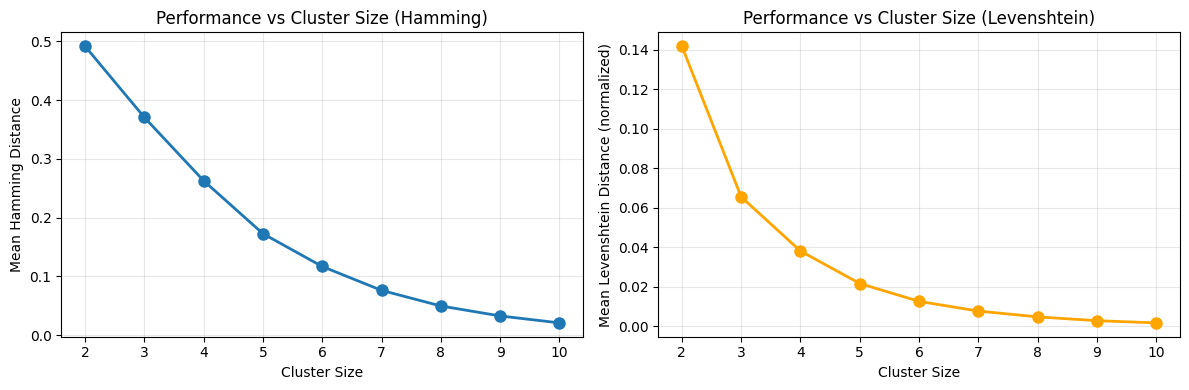

In [17]:
import matplotlib.pyplot as plt

# Plot performance vs cluster size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cluster_sizes_sorted = sorted(by_cluster.keys())
mean_hamming_by_size = [np.mean([r['hamming'] for r in by_cluster[size]]) for size in cluster_sizes_sorted]
mean_lev_by_size = [np.mean([r['levenshtein'] for r in by_cluster[size]]) for size in cluster_sizes_sorted]

# Hamming distance
ax1.plot(cluster_sizes_sorted, mean_hamming_by_size, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Cluster Size')
ax1.set_ylabel('Mean Hamming Distance')
ax1.set_title('Performance vs Cluster Size (Hamming)')
ax1.grid(True, alpha=0.3)

# Levenshtein distance
ax2.plot(cluster_sizes_sorted, mean_lev_by_size, 'o-', linewidth=2, markersize=8, color='orange')
ax2.set_xlabel('Cluster Size')
ax2.set_ylabel('Mean Levenshtein Distance (normalized)')
ax2.set_title('Performance vs Cluster Size (Levenshtein)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Example Predictions

Show a few example predictions:

In [18]:
# Show 5 random examples
import random

sample_results = random.sample(all_results, min(5, len(all_results)))

print("\nEXAMPLE PREDICTIONS")
print("="*80)

for i, r in enumerate(sample_results, 1):
    print(f"\nExample {i} (Cluster size: {r['cluster_size']})")
    print(f"  Hamming: {r['hamming']}, Levenshtein: {r['levenshtein']:.4f}")
    print(f"  Ground Truth: {r['ground_truth']}")
    print(f"  Prediction:   {r['prediction']}")
    
    # Show differences
    if r['hamming'] > 0:
        diff_positions = [i for i, (a, b) in enumerate(zip(r['ground_truth'], r['prediction'])) if a != b]
        print(f"  Differences at positions: {diff_positions[:10]}{'...' if len(diff_positions) > 10 else ''}")


EXAMPLE PREDICTIONS

Example 1 (Cluster size: 8)
  Hamming: 0.0, Levenshtein: 0.0000
  Ground Truth: CAGTGAAATATGATATCGTCCGTCATAACCAGGCGGAGGCCCTTCTGGTGCTATGCCGCGTCTTTAACGACTTTACAGCTAACATGATACGTTTCACGCTCGGTGAATAC
  Prediction:   CAGTGAAATATGATATCGTCCGTCATAACCAGGCGGAGGCCCTTCTGGTGCTATGCCGCGTCTTTAACGACTTTACAGCTAACATGATACGTTTCACGCTCGGTGAATAC

Example 2 (Cluster size: 3)
  Hamming: 0.5, Levenshtein: 0.0636
  Ground Truth: TATGCGCCGAGTAGGTACCTCGGAACTATCCATAAACATCCTAGATCATTCTGGTAAGAGTACATAATTATGCAGACTGTTGCCGACGAGAGTCTTTTAGTGACACTGAG
  Prediction:   TATGCCGCCGAGTAGGTACCCGGAACTATCCATAAACATCCTAGATCATTCTGTAAGAGTATTAATTATGCAGACTGTTGCCGACGAGAGGTCTTTTAGTGACACTAGAG
  Differences at positions: [5, 6, 8, 9, 10, 11, 12, 13, 15, 16]...

Example 3 (Cluster size: 5)
  Hamming: 0.12727272727272726, Levenshtein: 0.0182
  Ground Truth: TACCGCAACGTTCGTTCCGGTTCCAGCGCCCGCACTTTACCTCTTCGTATTTGCCAAAGAGCTGCCTAATACCCCGTAACGCCAATTGCTCGGCTCGAGCTCTCCCCTAG
  Prediction:   TACCGCAACGTTCGTTCCGGTTCCAGCGCCCGCACTTTACCTCTTCGTA

## Next Steps

**To use TReconLM on your own data:**
- See `custom_data.ipynb` for:
  - Loading your own formatted `reads.txt` and `ground_truth.txt`
  - Using Microsoft DNA dataset (requires running `data/microsoft_data/microsoft_data.ipynb`)
  - Using Noisy DNA dataset (requires running `data/noisy_dna/noisyDNA_data.ipynb`)

**To fine-tune models on your own data:**
- See `src/finetune.py` and training configs in `src/hydra/`